# Analyses descriptives des données "Open Food Facts"

## I - Paramétrage de l'environnement

In [1]:
# importation des librairies nécessaires

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scipy.stats as stats
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                      plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            an = np.linspace(0, 2 * np.pi, 100)  # Add a unit circle for scale
            plt.plot(np.cos(an), np.sin(an))
            plt.axis('equal')

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

In [3]:
# paramétrage de la palette de couleurs Seaborn
sns.set_theme(style="ticks", palette="Pastel2")

In [4]:
filepath = 'datasets/openfoodfacts_clean_median.csv'

In [5]:
# chargement du fichier
df = pd.read_csv(filepath)
df.head(3)

,code,url,creator,product_name,quantity,brands,categories,countries,ingredients_text,serving_size,...,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,created_years,last_modified_years
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,Nutrinet-sante,Jeunes pousses,NaN,Endives,unknown,France,NaN,NaN,...,263.0,7.1,1.79,17.4,3.57,2.15,6.1,0.220472,2021,2021
1,0000000000017,http://world-en.openfoodfacts.org/product/0000...,Kiliweb,Vitória crackers,NaN,NaN,unknown,France,NaN,NaN,...,375.0,7.0,3.08,70.1,15.00,2.15,7.8,0.560000,2018,2019
2,0000000000031,http://world-en.openfoodfacts.org/product/0000...,Isagoofy,Cacao,130 g,NaN,unknown,France,NaN,NaN,...,263.0,7.1,1.79,17.4,3.57,2.15,6.1,0.220472,2018,2018


In [6]:
df.columns

Index(['code', 'url', 'creator', 'product_name', 'quantity', 'brands',
       'categories', 'countries', 'ingredients_text', 'serving_size',
       'serving_quantity', 'additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'states', 'main_category', 'image_url', 'image_ingredients_url',
       'image_nutrition_url', 'energy-kcal_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'sodium_100g', 'created_years', 'last_modified_years'],
      dtype='object')

In [7]:
# suppression des colonnes qui ne vont pas être utiles à l'analyse
col_drop = ['code', 'url', 'creator', 'quantity', 'ingredients_text', 'serving_quantity', 'serving_size', 'states',
            'main_category', 'image_url', 'image_ingredients_url', 'image_nutrition_url'] 

df.drop(col_drop, axis=1, inplace=True)

In [8]:
# transformation des variables catégorielles en catégorie
col_cat = ["countries", "ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_n",
           "nutriscore_score", "nutriscore_grade"]

for col in col_cat:
    df[col] = df[col].astype("category")

In [9]:
palm_oil = ["ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_n", "additives_n"]

for col in palm_oil:
    df[col] = df[col].astype("int64")

In [10]:
df.shape

(1751837, 22)

In [11]:
# Suppression des colonnes avec plus de 70% de valeurs manquantes
df = df.loc[:, df.isnull().mean() <.70]

<AxesSubplot:>

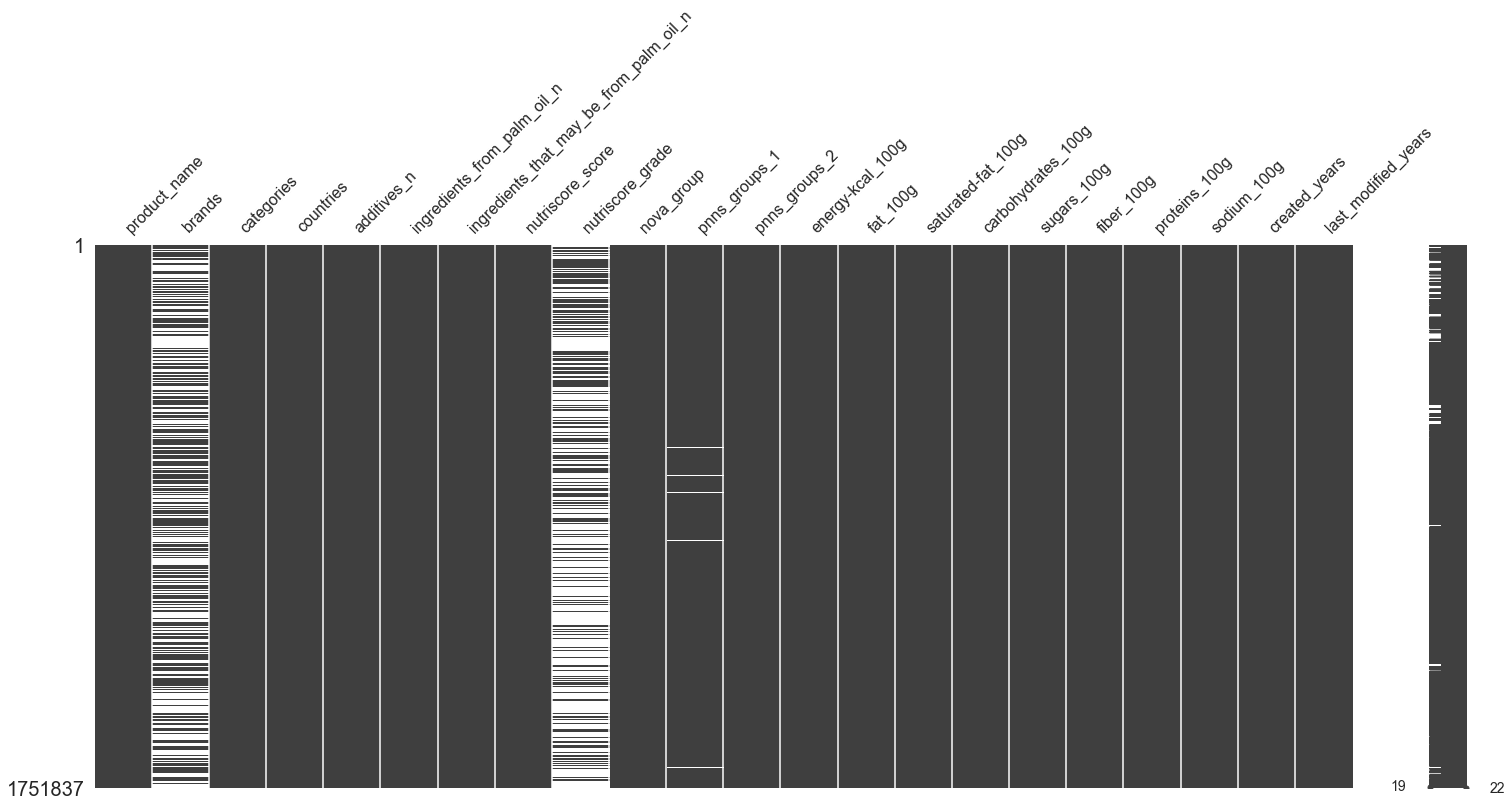

In [12]:
msno.matrix(df)

In [13]:
# Retrait des valeurs manquantes
df.dropna(inplace=True)

In [14]:
df.shape

(481982, 22)

## II -  Analyses univariées

On va réaliser une analyse univariée de nos différentes variables pour voir leur comportement. On va commencer par s'intéresser aux variables catégorielles avant de se pencher sur les variables quantitatives. 

### a) Description des variables qualitatives

- Les pays

In [15]:
print('Nombre de pays :', len(df['countries'].unique()))

Nombre de pays : 316


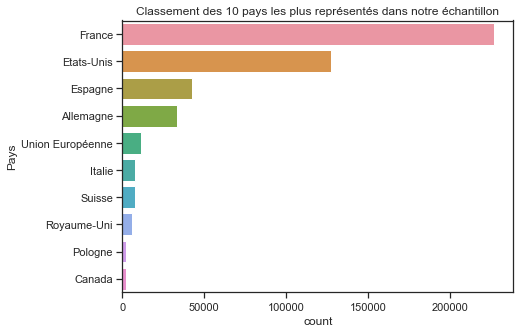

In [16]:
plt.figure(figsize=(7,5))
sns.countplot(y="countries", data=df, order=pd.value_counts(df['countries']).iloc[:10].index)
plt.ylabel("Pays")
plt.title("Classement des 10 pays les plus représentés dans notre échantillon")
plt.savefig("Présentation/Images/top_10_pays.png")
plt.show()

Pour la suite de notre étude, on va se pencher sur l'analyse des données uniquement pour la France. 

In [17]:
df_france = df.loc[df['countries'] == 'France']
df_france.shape

(227393, 22)

- Les types de produits

In [18]:
print('Nombre de produits :', len(df_france['product_name']))

Nombre de produits : 227393


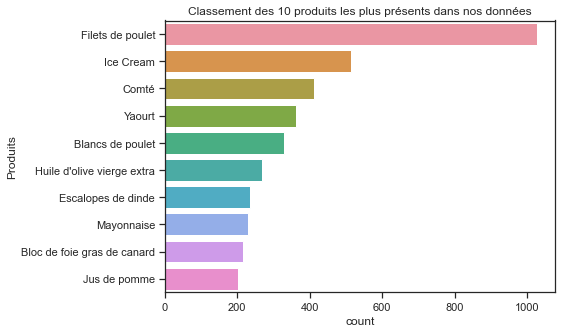

In [19]:
plt.figure(figsize=(7, 5))
sns.countplot(y="product_name", data=df_france, order=pd.value_counts(df_france['product_name']).iloc[:10].index)
plt.ylabel("Produits")
plt.title("Classement des 10 produits les plus présents dans nos données")
plt.savefig("Présentation/Images/top_10_produits.png")
plt.show()

- Les marques de distributeurs

In [20]:
print('Nombre de marques :', len(df_france['brands'].unique()))

Nombre de marques : 36180


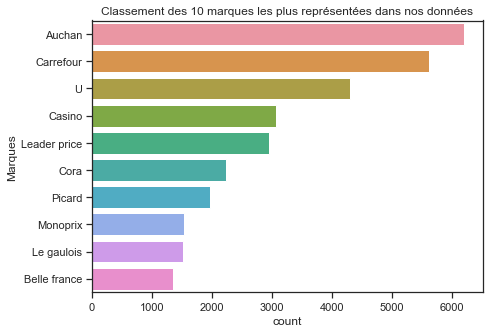

In [21]:
plt.figure(figsize=(7, 5))
sns.countplot(y="brands", data=df_france, order=pd.value_counts(df_france['brands']).iloc[:10].index)
plt.ylabel("Marques")
plt.title("Classement des 10 marques les plus représentées dans nos données")
plt.savefig("Présentation/Images/top_10_marques.png")
plt.show()

- Les années de création et de modification

In [22]:
print("Nombre d'années de création : ", len(df_france["created_years"].unique()))
print("Année avec le plus d'ajout de produits :", df_france['created_years'].mode()[0])
print("Nombre d'années de modification : ", len(df_france['last_modified_years'].unique()))
print("Année avec le plus de mise à jour de produits :", df_france['last_modified_years'].mode()[0])

Nombre d'années de création :  10
Année avec le plus d'ajout de produits : 2018
Nombre d'années de modification :  10
Année avec le plus de mise à jour de produits : 2021


### b) Distribution des variables catégorielles

Les variables ci-dessous possèdent un nombre de modalités limité. On va donc les représenter sous forme d'histogrammes. 

In [23]:
df_france['nutriscore_grade'] = df_france['nutriscore_grade'].replace("a", "A")
df_france['nutriscore_grade'] = df_france['nutriscore_grade'].replace("b", "B")
df_france['nutriscore_grade'] = df_france['nutriscore_grade'].replace("c", "C")
df_france['nutriscore_grade'] = df_france['nutriscore_grade'].replace("d", "D")
df_france['nutriscore_grade'] = df_france['nutriscore_grade'].replace("e", "E")

In [24]:
df_france["palm_oil_tot"] = df_france["ingredients_from_palm_oil_n"] + df_france["ingredients_that_may_be_from_palm_oil_n"]

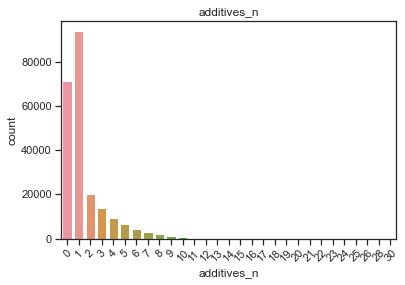

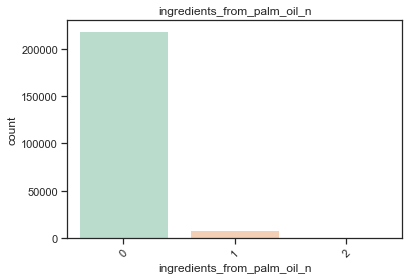

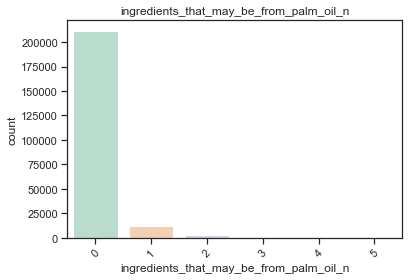

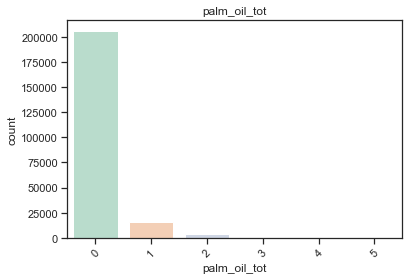

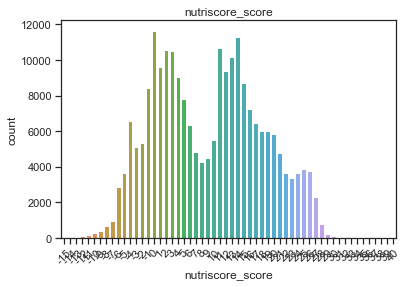

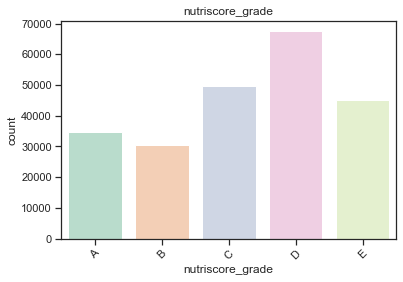

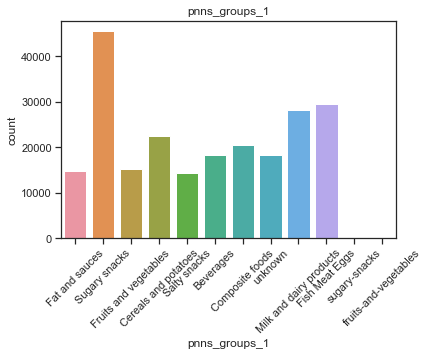

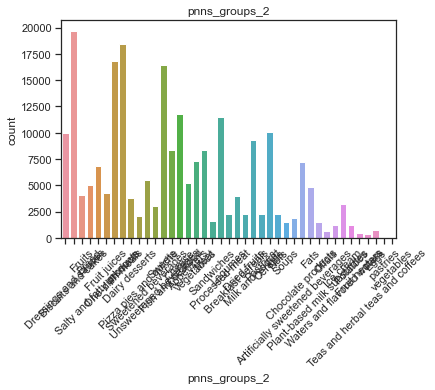

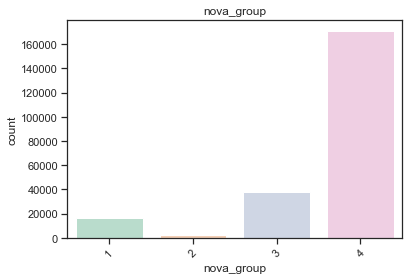

In [25]:
col_cat = ["additives_n", "ingredients_from_palm_oil_n", "ingredients_that_may_be_from_palm_oil_n", "palm_oil_tot",
           "nutriscore_score", "nutriscore_grade", "pnns_groups_1", "pnns_groups_2", "nova_group"]

for col in col_cat:
    sns.countplot(x=col, data=df_france)
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

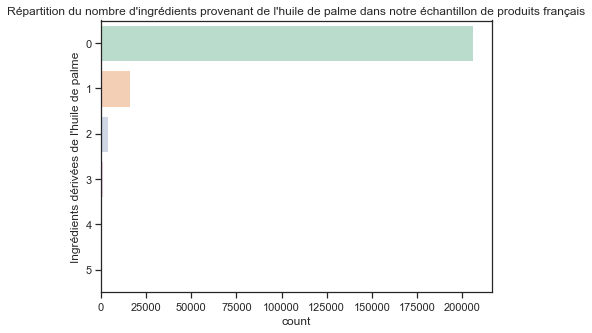

In [26]:
plt.figure(figsize=(7,5))
sns.countplot(y="palm_oil_tot", data=df_france)
plt.ylabel("Ingrédients dérivées de l'huile de palme")
plt.title("Répartition du nombre d'ingrédients provenant de l'huile de palme dans notre échantillon de produits français")
plt.savefig("Présentation/Images/palm_oil.png")
plt.show()

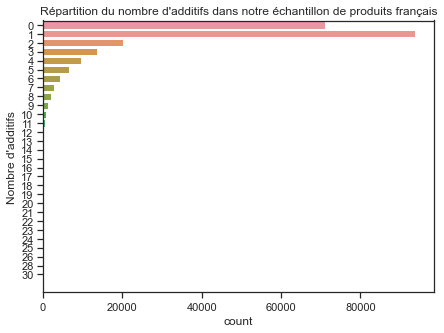

In [27]:
plt.figure(figsize=(7,5))
sns.countplot(y="additives_n", data=df_france)
plt.ylim(30)
plt.ylabel("Nombre d'additifs")
plt.title("Répartition du nombre d'additifs dans notre échantillon de produits français")
plt.savefig("Présentation/Images/additives.png")
plt.show()

### c) Description de la distribution des variables quantitatives

On va générer des histogrammes pour évaluer la distribution de chacune de nos variables quantitatives.

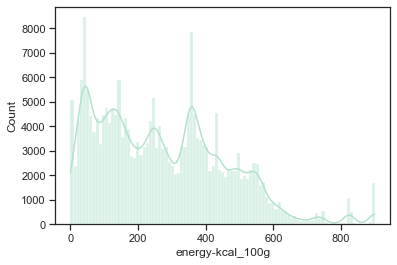

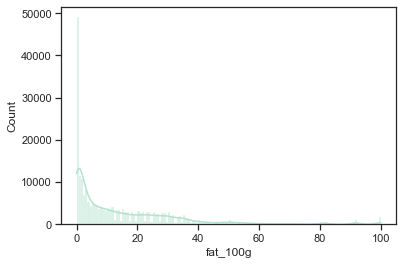

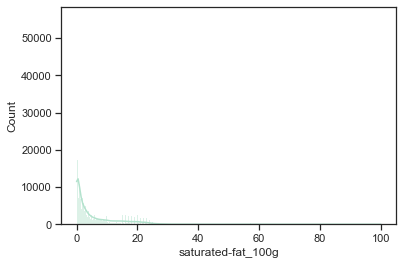

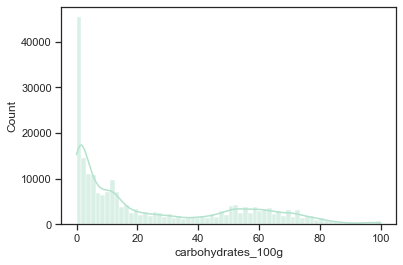

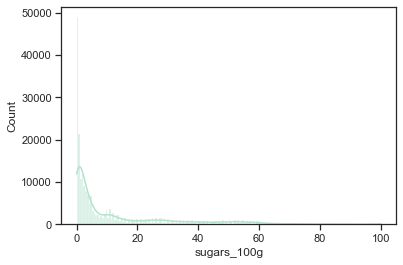

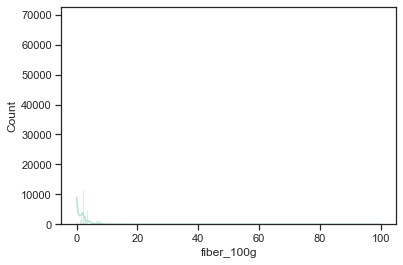

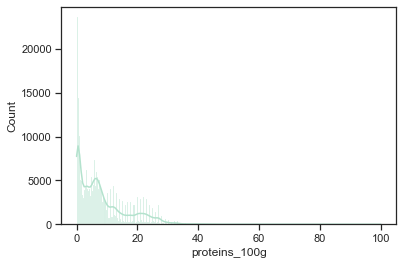

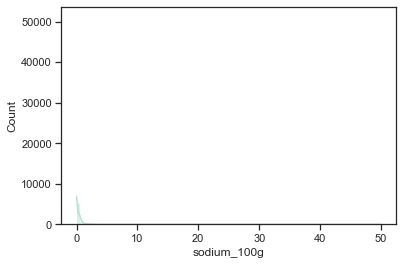

In [28]:
for var in df_france.columns:
    if df_france[var].dtypes == 'float64':
        sns.histplot(x=var, data=df_france, kde=True)
        plt.show()

On accompagne ces visualisations d'un test de normalité. Ici, nous avons choisi le test de Kolmogorov-Smirnov qui est le plus adapté à notre échantillon.

In [29]:
pg.normality(df_france, method='normaltest', alpha=0.05)

,W,pval,normal
additives_n,132948.119653,0.0,False
ingredients_from_palm_oil_n,227943.848584,0.0,False
ingredients_that_may_be_from_palm_oil_n,223739.578952,0.0,False
nova_group,96483.282855,0.0,False
energy-kcal_100g,13863.566876,0.0,False
fat_100g,97492.664327,0.0,False
saturated-fat_100g,167454.180227,0.0,False
carbohydrates_100g,33572.623296,0.0,False
sugars_100g,76332.634592,0.0,False
fiber_100g,293879.194607,0.0,False


On réalise ensuite un test sur l'homogénéité de nos variances dans notre échantillon. Le choix s'est porté sur un test de Levene car il est plus efficace lorsque les distributions ne suivent pas une loi normale. Dans le cas contraire, nous aurions utilisé un test de Bartlett. 

In [30]:
pg.homoscedasticity(df_france, method='levene', alpha=0.05)

,W,pval,equal_var
levene,0.006794,1.0,True


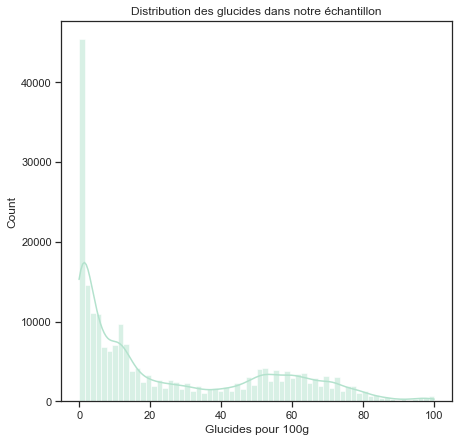

In [31]:
plt.figure(figsize=(7,7))
sns.histplot(x="carbohydrates_100g", data=df_france, kde=True)
plt.title('Distribution des glucides dans notre échantillon')
plt.xlabel("Glucides pour 100g")
plt.savefig("Présentation/Images/carbohydrates_distribution.png")
plt.show()

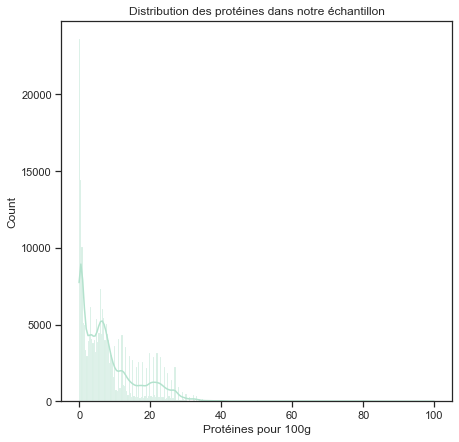

In [32]:
plt.figure(figsize=(7,7))
sns.histplot(x="proteins_100g", data=df_france, kde=True)
plt.title('Distribution des protéines dans notre échantillon')
plt.xlabel("Protéines pour 100g")
plt.savefig("Présentation/Images/proteins_distribution.png")
plt.show()

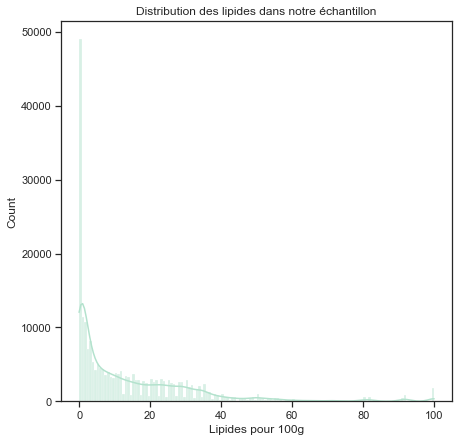

In [33]:
plt.figure(figsize=(7,7))
sns.histplot(x="fat_100g", data=df_france, kde=True)
plt.title('Distribution des lipides dans notre échantillon')
plt.xlabel("Lipides pour 100g")
plt.savefig("Présentation/Images/fat_distribution.png")
plt.show()

**Conclusion :**

Aucune de nos variables ne suit une loi normale. En revanche, selon le test de Levene avec un alpha à 0.05, les variances de nos variables quantitatives sont homogènes. 

### d) Analyses descriptives des variables

#### Analyses graphiques des variables

Après avoir regardé la distribution de nos variables, on va s'intéresser à leur comportement. On va donc représenter ces dernières sous forme de boîte à moustache pour avoir une idée rapide de la manière dont elle se comporte. 

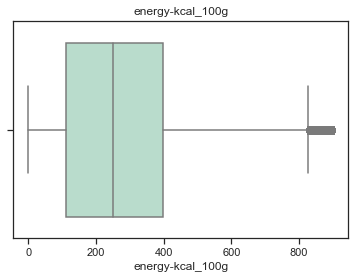

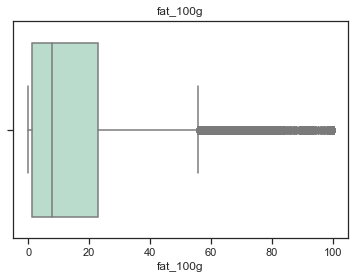

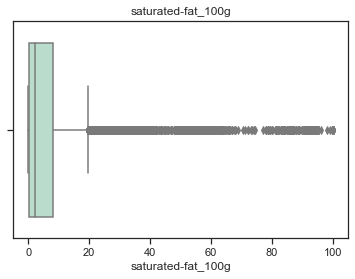

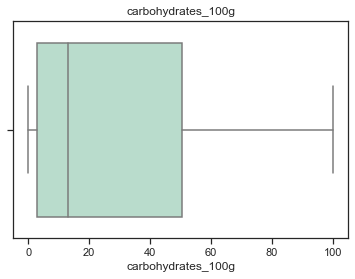

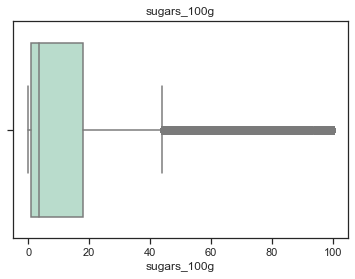

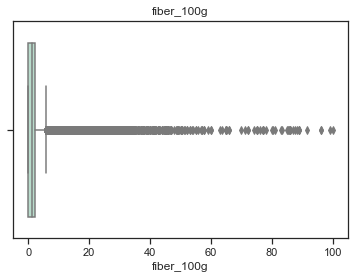

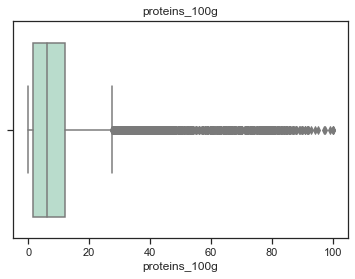

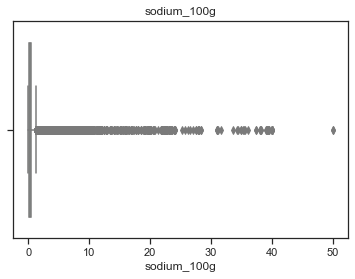

In [34]:
for var in df_france.columns:
    if df_france[var].dtypes == 'float64':
        sns.boxplot(x=var, data=df_france)
        plt.title(var)
        plt.show()

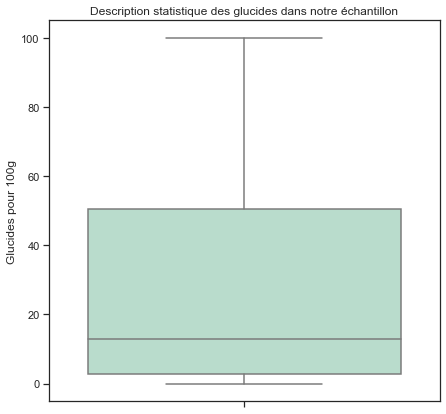

In [35]:
plt.figure(figsize=(7,7))
sns.boxplot(y="carbohydrates_100g", data=df_france)
plt.title('Description statistique des glucides dans notre échantillon')
plt.ylabel("Glucides pour 100g")
plt.savefig("Présentation/Images/carbohydrates_boxplot.png")
plt.show()

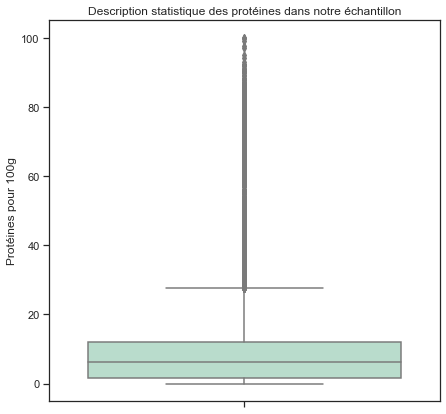

In [36]:
plt.figure(figsize=(7,7))
sns.boxplot(y="proteins_100g", data=df_france)
plt.title('Description statistique des protéines dans notre échantillon')
plt.ylabel("Protéines pour 100g")
plt.savefig("Présentation/Images/proteins_boxplot.png")
plt.show()

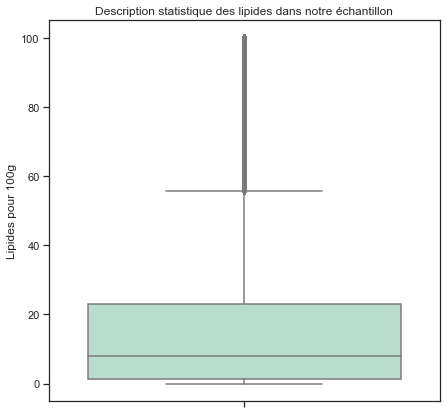

In [37]:
plt.figure(figsize=(7,7))
sns.boxplot(y="fat_100g", data=df_france)
plt.title('Description statistique des lipides dans notre échantillon')
plt.ylabel("Lipides pour 100g")
plt.savefig("Présentation/Images/lipides_boxplot.png")
plt.show()

#### Analyses statistiques des variables

On accompagne notre analyse visuelle par les données chiffrées décrivant nos données.

In [38]:
df_france.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nova_group,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,created_years,last_modified_years,palm_oil_tot
count,227393.000000,227393.000000,227393.000000,227393.000000,227393.000000,227393.000000,227393.000000,227393.000000,227393.000000,227393.000000,227393.000000,227393.000000,227393.000000,227393.000000,227393.000000
mean,1.521239,0.035344,0.088675,3.596399,272.388883,14.700628,5.662597,25.775918,12.966495,1.988582,8.378201,0.380970,2017.242822,2019.997014,0.124019
std,2.045745,0.187344,0.358077,0.834657,189.619047,18.409545,8.544001,26.737323,18.622955,3.243592,8.735621,0.931003,1.659898,1.152531,0.429994
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2012.000000,2012.000000,0.000000
25%,0.000000,0.000000,0.000000,4.000000,112.000000,1.200000,0.300000,2.800000,0.800000,0.000000,1.600000,0.024000,2017.000000,2019.000000,0.000000
50%,1.000000,0.000000,0.000000,4.000000,250.000000,7.900000,2.100000,13.000000,3.600000,1.200000,6.100000,0.200000,2018.000000,2020.000000,0.000000
75%,2.000000,0.000000,0.000000,4.000000,398.000000,23.000000,8.000000,50.500000,18.000000,2.300000,12.000000,0.480000,2018.000000,2021.000000,0.000000
max,30.000000,2.000000,5.000000,4.000000,900.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,50.000000,2021.000000,2021.000000,5.000000


## III - Hypothèses de travail

Notre jeu de données est composée de différentes variables : 
- Des variables en lien avec l'identification des produits (noms, endroits où ils sont commercialisés, date d'ajout dans la base, date de modification dans la base)
- Des variables qui mesurent la qualité des produits (nutriscore)
- Des variables sur les différentes valeurs nutrionnelles du produit (graisse, graisse saturée, carbohydrates, sucres, fibres, protéines, sel)
- Des variables sur l'énergie que l'on trouve dans chaque produit (énergie en kcal)

On peut se demander si la quantité d'ingrédients en lien avec l'huile de palme et le nombre d'additifs vont avoir un impact sur la composition nutrionnelle des aliments ainsi que l'énergie contenue dans ces aliments.

On peut aussi se demander si l'utilisation des données en lien avec les valeurs nutrionnelles du produit, l'énergie et sa composition peuvent être intéressantes à utiliser pour développer un score global que l'on pourra imputer à d'autres aliments.

## IV - Analyses bivariées des variables

### a) Analyses bivariées des variables quantitatives

#### Corrélation entre les variables quantitatives

On va d'abord étudier les corrélations entre les différentes variables à l'aide d'une matrice de corrélation.

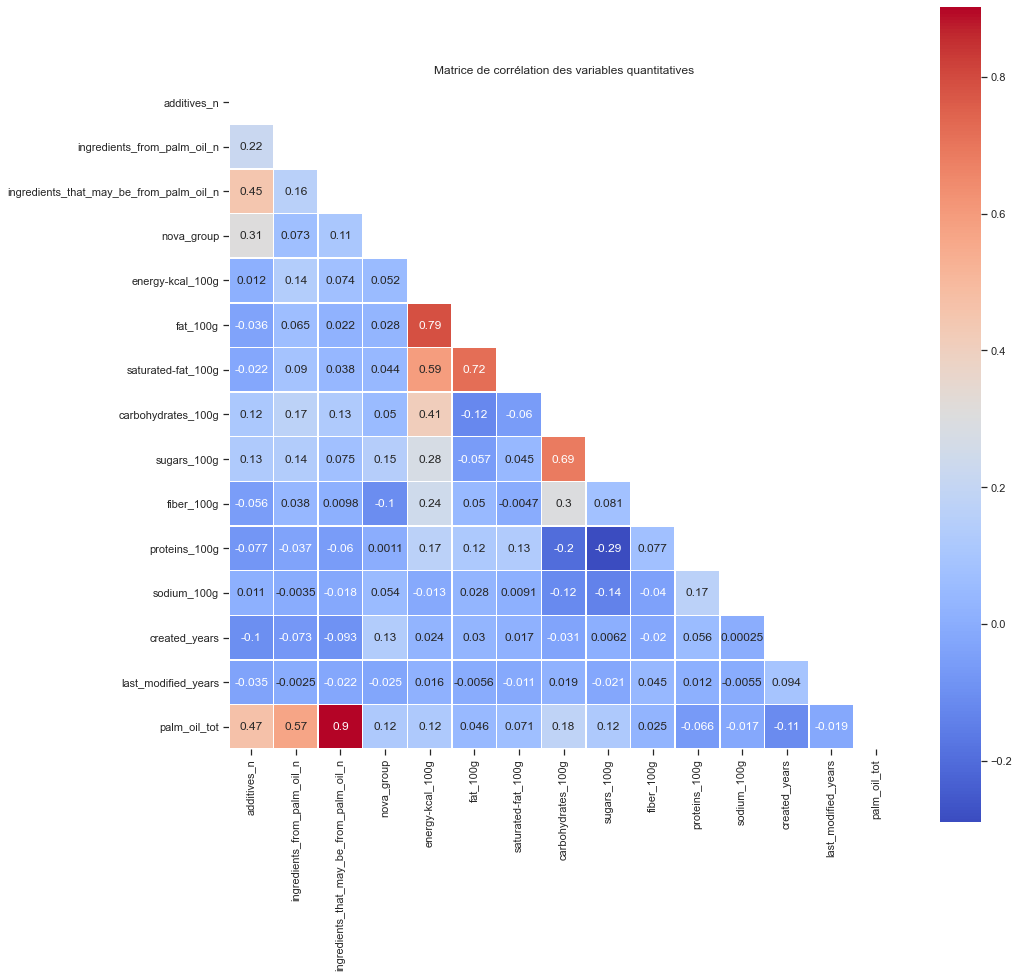

In [39]:
corr_matrix = df_france.corr()
mask = np.triu(corr_matrix)

plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, cmap="coolwarm", mask=mask, linewidths=.5, annot=True, cbar=True, square=True)
plt.title("Matrice de corrélation des variables quantitatives")
plt.savefig("Présentation/Images/matrice_corr.png")
plt.show()

La matrice de corrélation permet de voir les corrélations qui existent entre les différentes variables quantitatives. On ne va donc pas s'intéresser aux variables qualitatives comme les différents scores que l'on a pu voir plus haut. 
On remarque une forte corrélation positive entre la **quantité d'énergie en kcal pour 100g** et la **quantité de graisses pour 100g** *(0.8)*, la **quantité de graisses saturées pour 100g** *(0.59)* et la **quantité de carbohydrates pour 100g** *(0.4)*. De plus, on remarque une forte corrélation positive entre la **quantité de graisses pour 100g** et la **quantité de graisses saturées pour 100g** *(0.71)*. Enfin, on observe une dernière corrélation positive moyenne entre la **quantité de sucres pour 100g** et la **quantité de carbohydrates pour 100g** *(0.69)*. 

On va donc réaliser une régression linéaire en partant de ces corrélations pour mieux voir ce qui unit ces variables

#### Analyse de régression entre variables quantitatives

- Energie en Kcal et quantité de graisses pour 100g

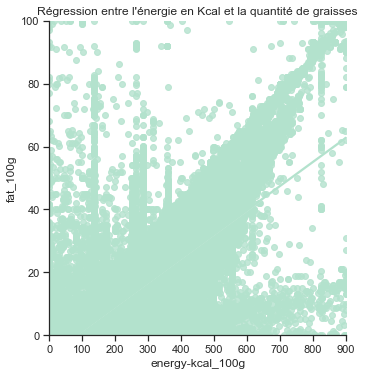

In [40]:
sns.lmplot(x="energy-kcal_100g", y="fat_100g", data=df_france)
plt.title("Régression entre l'énergie en Kcal et la quantité de graisses")
plt.xlim(df_france["energy-kcal_100g"].min(), df_france["energy-kcal_100g"].max())
plt.ylim(df_france["fat_100g"].min(), df_france["fat_100g"].max())
plt.show()

In [41]:
pg.linear_regression(X=df_france["energy-kcal_100g"], y=df_france["fat_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-6.187681,0.041441,-149.313826,0.0,0.623887,0.623885,-6.268904,-6.106459
1,energy-kcal_100g,0.076686,0.000125,614.157948,0.0,0.623887,0.623885,0.076441,0.076930


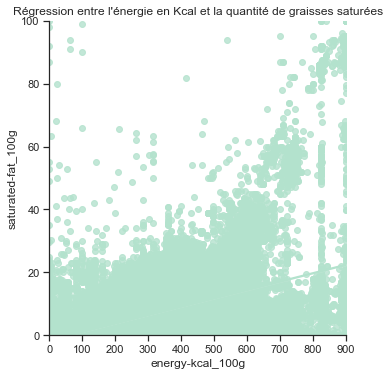

In [42]:
sns.lmplot(x="energy-kcal_100g", y="saturated-fat_100g", data=df_france)
plt.title("Régression entre l'énergie en Kcal et la quantité de graisses saturées")
plt.xlim(df_france["energy-kcal_100g"].min(), df_france["energy-kcal_100g"].max())
plt.ylim(df_france["saturated-fat_100g"].min(), df_france["saturated-fat_100g"].max())
plt.show()

In [43]:
pg.linear_regression(X=df_france["energy-kcal_100g"], y=df_france["saturated-fat_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,-1.608290,0.025266,-63.655571,0.0,0.350944,0.350941,-1.657810,-1.558770
1,energy-kcal_100g,0.026693,0.000076,350.642148,0.0,0.350944,0.350941,0.026544,0.026842


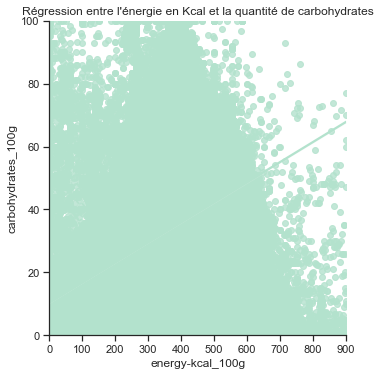

In [44]:
sns.lmplot(x="energy-kcal_100g", y="carbohydrates_100g", data=df)
plt.title("Régression entre l'énergie en Kcal et la quantité de carbohydrates")
plt.xlim(df_france["energy-kcal_100g"].min(), df_france["energy-kcal_100g"].max())
plt.ylim(df_france["carbohydrates_100g"].min(), df_france["carbohydrates_100g"].max())
plt.show()

In [45]:
pg.linear_regression(X=df_france["energy-kcal_100g"], y=df_france["carbohydrates_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,10.061479,0.089549,112.356799,0.0,0.167397,0.167393,9.885964,10.236993
1,energy-kcal_100g,0.057691,0.000270,213.816454,0.0,0.167397,0.167393,0.057162,0.058220


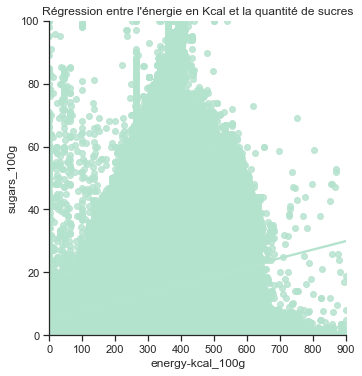

In [46]:
sns.lmplot(x="energy-kcal_100g", y="sugars_100g", data=df_france)
plt.title("Régression entre l'énergie en Kcal et la quantité de sucres")
plt.xlim(df_france["energy-kcal_100g"].min(), df_france["energy-kcal_100g"].max())
plt.ylim(df_france["sugars_100g"].min(), df_france["sugars_100g"].max())
plt.show()

In [47]:
pg.linear_regression(X=df_france["energy-kcal_100g"], y=df_france["sugars_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,5.586779,0.065703,85.030397,0.0,0.076097,0.076093,5.458002,5.715556
1,energy-kcal_100g,0.027093,0.000198,136.853873,0.0,0.076097,0.076093,0.026705,0.027481


- Graisses et graisses saturées

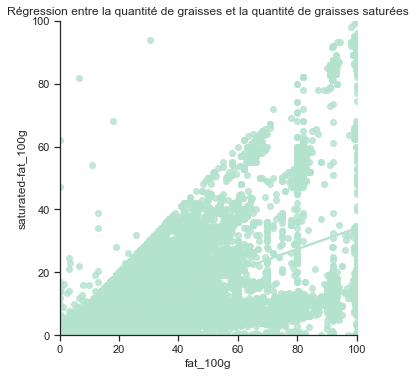

In [48]:
sns.lmplot(x="fat_100g", y="saturated-fat_100g", data=df_france)
plt.title("Régression entre la quantité de graisses et la quantité de graisses saturées")
plt.xlim(df_france["fat_100g"].min(), df_france["fat_100g"].max())
plt.ylim(df_france["saturated-fat_100g"].min(), df_france["saturated-fat_100g"].max())
plt.show()

In [49]:
pg.linear_regression(X=df_france["fat_100g"], y=df_france["saturated-fat_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,0.769358,0.015978,48.149876,0.0,0.514381,0.514378,0.738041,0.800675
1,fat_100g,0.332859,0.000678,490.773258,0.0,0.514381,0.514378,0.331530,0.334189


- Carbohydrates et sucres

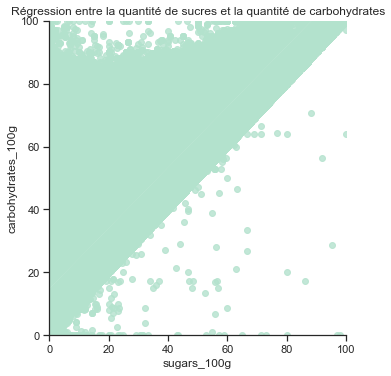

In [50]:
sns.lmplot(x="sugars_100g", y="carbohydrates_100g", data=df)
plt.title("Régression entre la quantité de sucres et la quantité de carbohydrates")
plt.xlim(df_france["sugars_100g"].min(), df_france["sugars_100g"].max())
plt.ylim(df_france["carbohydrates_100g"].min(), df_france["carbohydrates_100g"].max())
plt.show()

In [51]:
pg.linear_regression(X=df_france["sugars_100g"], y=df_france["carbohydrates_100g"], add_intercept=True, alpha=0.05)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,12.997799,0.049686,261.599676,0.0,0.47114,0.471138,12.900416,13.095182
1,sugars_100g,0.985472,0.002190,450.081625,0.0,0.47114,0.471138,0.981181,0.989764


### b) Analyses bivariées des variables qualitatives et quantitatives

#### Analyses entre la quantité de graisse et les différentes variables qualitatives

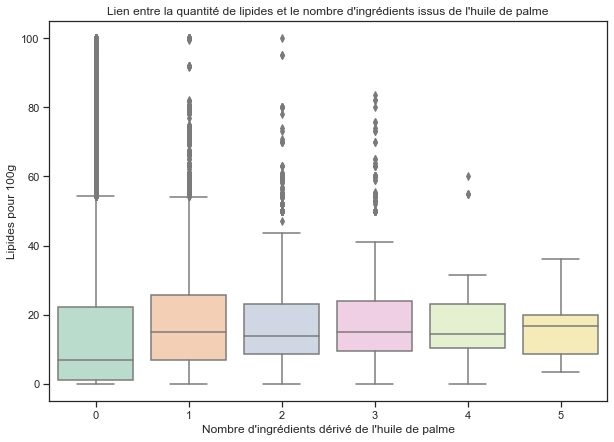

In [52]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="palm_oil_tot", y="fat_100g", data=df_france)
plt.xlabel("Nombre d'ingrédients dérivé de l'huile de palme")
plt.ylabel("Lipides pour 100g")
plt.title("Lien entre la quantité de lipides et le nombre d'ingrédients issus de l'huile de palme")
plt.savefig("Présentation/Images/huile_de_palm_vs_graisses.png")
plt.show()

In [53]:
pg.anova(data=df_france, dv="fat_100g", between="palm_oil_tot")

,Source,ddof1,ddof2,F,p-unc,np2
0,palm_oil_tot,5,227387,129.73463,9.681975e-138,0.002845


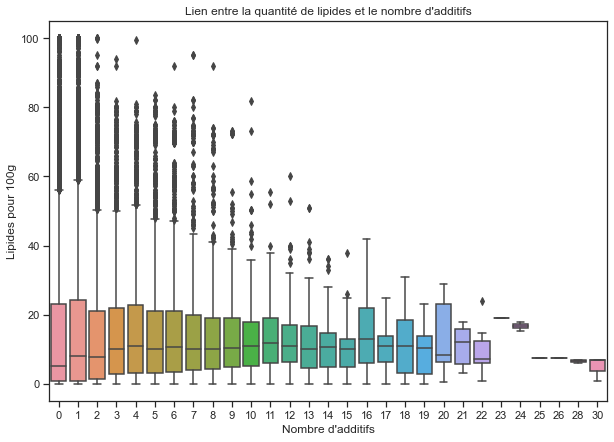

In [54]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="additives_n", y="fat_100g", data=df_france)
plt.xlabel("Nombre d'additifs")
plt.ylabel("Lipides pour 100g")
plt.title("Lien entre la quantité de lipides et le nombre d'additifs")
plt.savefig("Présentation/Images/additifs_vs_lipides.png")
plt.show()

In [55]:
pg.anova(data=df_france, dv="fat_100g", between="additives_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,additives_n,28,227364,16.213018,2.340649e-78,0.001993


#### Analyses entre la quantité de sucre et les différentes variables qualitatives

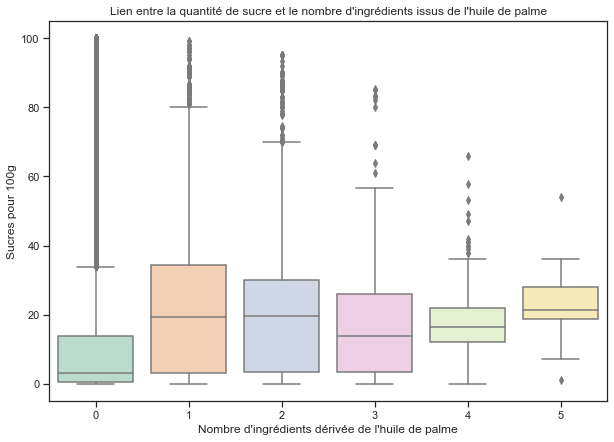

In [56]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="palm_oil_tot", y="sugars_100g", data=df_france)
plt.title("Lien entre la quantité de sucre et le nombre d'ingrédients issus de l'huile de palme")
plt.xlabel("Nombre d'ingrédients dérivée de l'huile de palme")
plt.ylabel("Sucres pour 100g")
plt.show()

In [57]:
pg.anova(data=df_france, dv="sugars_100g", between="palm_oil_tot")

,Source,ddof1,ddof2,F,p-unc,np2
0,palm_oil_tot,5,227387,973.287446,0.0,0.020953


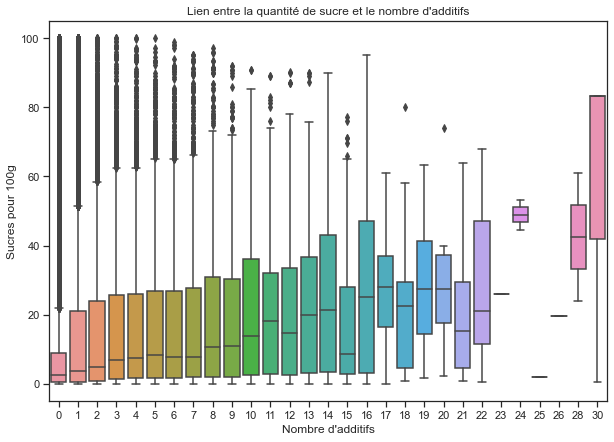

In [58]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="additives_n", y="sugars_100g", data=df_france)
plt.title("Lien entre la quantité de sucre et le nombre d'additifs")
plt.xlabel("Nombre d'additifs")
plt.ylabel("Sucres pour 100g")
plt.show()

In [59]:
pg.anova(data=df_france, dv="sugars_100g", between="additives_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,additives_n,28,227364,212.182848,0.0,0.025465


#### Analyses entre la quantité de protéines et les différentes variables qualitatives

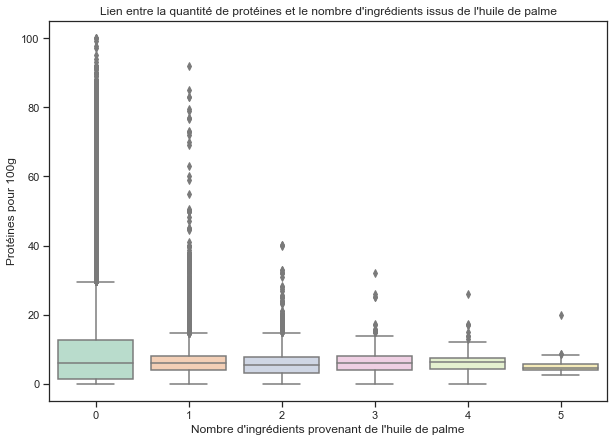

In [60]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="palm_oil_tot", y="proteins_100g", data=df_france)
plt.xlabel("Nombre d'ingrédients provenant de l'huile de palme")
plt.ylabel("Protéines pour 100g")
plt.title("Lien entre la quantité de protéines et le nombre d'ingrédients issus de l'huile de palme")
plt.savefig("Présentation/Images/palm_oil_vs_proteins.png")
plt.show()

In [61]:
pg.anova(data=df_france, dv="proteins_100g", between="palm_oil_tot")

,Source,ddof1,ddof2,F,p-unc,np2
0,palm_oil_tot,5,227387,223.791978,4.100628e-239,0.004897


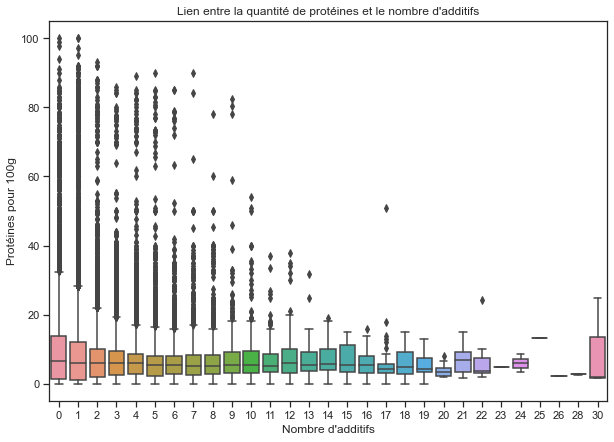

In [62]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="additives_n", y="proteins_100g", data=df_france)
plt.xlabel("Nombre d'additifs")
plt.ylabel("Protéines pour 100g")
plt.title("Lien entre la quantité de protéines et le nombre d'additifs")
plt.savefig("Présentation/Images/additifs_vs_proteins.png")
plt.show()

In [63]:
pg.anova(data=df_france, dv="proteins_100g", between="additives_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,additives_n,28,227364,56.173938,2.815192e-313,0.00687


#### Analyses entre la quantité de carbohydrates et les différentes variables quanlitatives

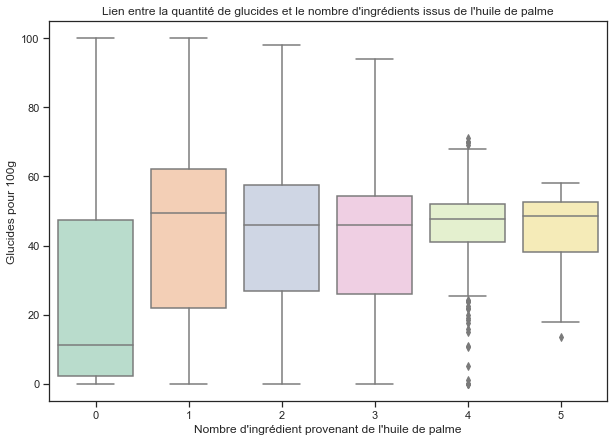

In [64]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="palm_oil_tot", y="carbohydrates_100g", data=df_france)
plt.title("Lien entre la quantité de glucides et le nombre d'ingrédients issus de l'huile de palme")
plt.xlabel("Nombre d'ingrédient provenant de l'huile de palme")
plt.ylabel("Glucides pour 100g")
plt.savefig("Présentation/Images/carbohydrates_vs_palm_oil.png")
plt.show()

In [65]:
pg.anova(data=df_france, dv="carbohydrates_100g", between="palm_oil_tot")

,Source,ddof1,ddof2,F,p-unc,np2
0,palm_oil_tot,5,227387,2017.777074,0.0,0.042484


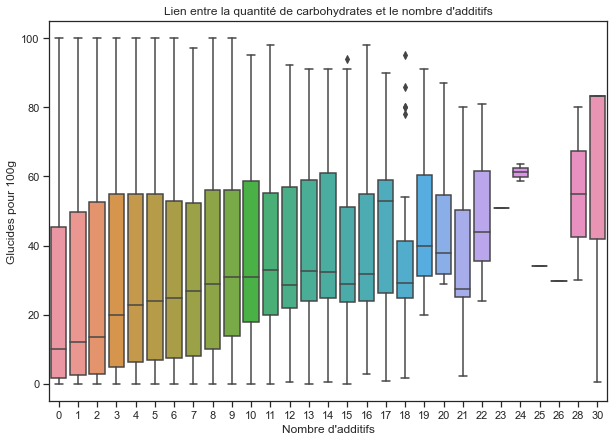

In [66]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="additives_n", y="carbohydrates_100g", data=df_france)
plt.title("Lien entre la quantité de carbohydrates et le nombre d'additifs")
plt.xlabel("Nombre d'additifs")
plt.ylabel("Glucides pour 100g")
plt.savefig("Présentation/Images/carbohydrates_vs_additifs.png")
plt.show()

In [67]:
pg.anova(data=df_france, dv="carbohydrates_100g", between="additives_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,additives_n,28,227364,116.31173,0.0,0.014122


#### Analyses entre la quantité de sel et les différentes variables qualitatives

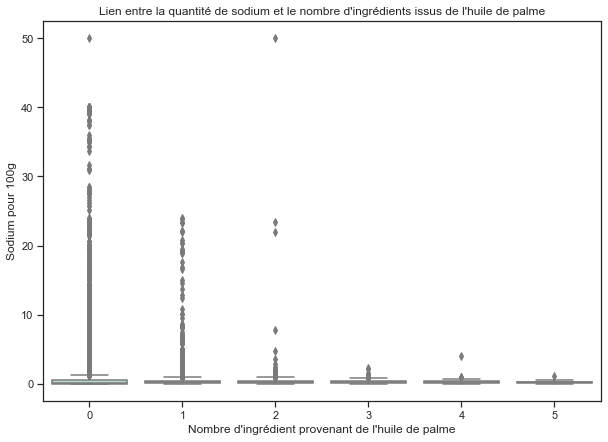

In [68]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="palm_oil_tot", y="sodium_100g", data=df_france)
plt.title("Lien entre la quantité de sodium et le nombre d'ingrédients issus de l'huile de palme")
plt.xlabel("Nombre d'ingrédient provenant de l'huile de palme")
plt.ylabel("Sodium pour 100g")
plt.show()

In [69]:
pg.anova(data=df_france, dv="sodium_100g", between="palm_oil_tot")

,Source,ddof1,ddof2,F,p-unc,np2
0,palm_oil_tot,5,227387,14.19801,6.408429e-14,0.000312


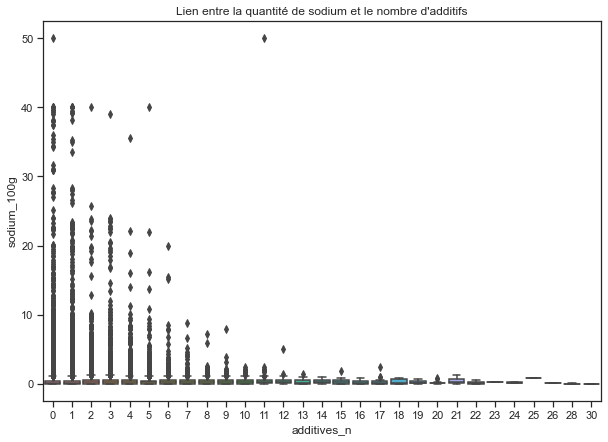

In [70]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="additives_n", y="sodium_100g", data=df_france)
plt.title("Lien entre la quantité de sodium et le nombre d'additifs")
plt.show()

In [71]:
pg.anova(data=df_france, dv="sodium_100g", between="additives_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,additives_n,28,227364,13.772517,1.844250e-64,0.001693


#### Analyses entre la quantité d'énergie et les différentes variables qualitatives

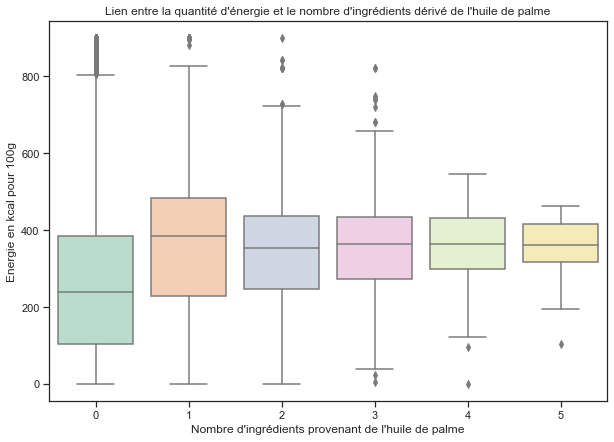

In [72]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="palm_oil_tot", y="energy-kcal_100g", data=df_france)
plt.title("Lien entre la quantité d'énergie et le nombre d'ingrédients dérivé de l'huile de palme")
plt.xlabel("Nombre d'ingrédients provenant de l'huile de palme")
plt.ylabel("Energie en kcal pour 100g")
plt.savefig("Présentation/Images/energy-kcal_vs_palm_oil.png")
plt.show()

In [73]:
pg.anova(data=df_france, dv="energy-kcal_100g", between="palm_oil_tot")

,Source,ddof1,ddof2,F,p-unc,np2
0,palm_oil_tot,5,227387,912.139596,0.0,0.019663


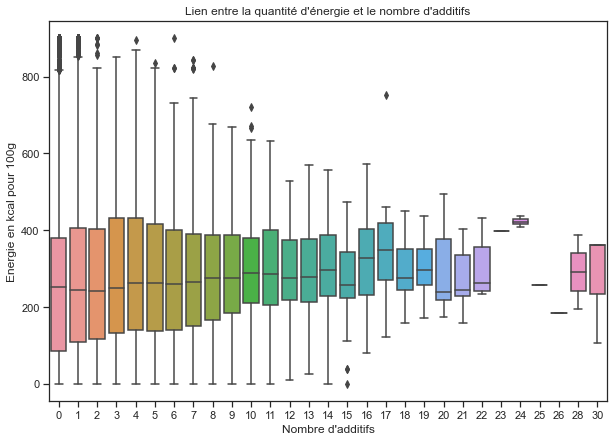

In [74]:
plt.figure(figsize=(10, 7))
sns.boxplot(x="additives_n", y="energy-kcal_100g", data=df_france)
plt.title("Lien entre la quantité d'énergie et le nombre d'additifs")
plt.xlabel("Nombre d'additifs")
plt.ylabel("Energie en kcal pour 100g")
plt.savefig("Présentation/Images/energy-kcal_vs_additives.png")
plt.show()

In [75]:
pg.anova(data=df_france, dv="energy-kcal_100g", between="additives_n")

,Source,ddof1,ddof2,F,p-unc,np2
0,additives_n,28,227364,5.639398,4.660036e-20,0.000694


## c) Analyses bivariées entre les variables qualitatives

- Nombre d'ingrédients issus de l'huile de palme et nombre d'additifs

In [76]:
expected, observed, stats = pg.chi2_independence(data=df_france, x="palm_oil_tot", y="additives_n")
stats.round(3)

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000,75568.414,140.0,0.0,0.258,1.0
1,cressie-read,0.667,49071.302,140.0,0.0,0.208,1.0
2,log-likelihood,0.000,37246.585,140.0,0.0,0.181,1.0
3,freeman-tukey,-0.500,NaN,140.0,NaN,NaN,NaN
4,mod-log-likelihood,-1.000,inf,140.0,0.0,inf,1.0
5,neyman,-2.000,NaN,140.0,NaN,NaN,NaN


In [77]:
contingency = pd.crosstab(index=df_france["palm_oil_tot"], columns=df_france["additives_n"], margins=True)

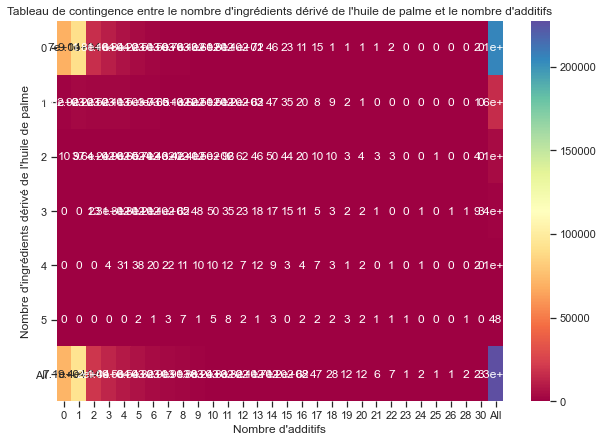

In [78]:
plt.figure(figsize=(10,7))
sns.heatmap(contingency, annot=True, cmap="Spectral")
plt.xlabel("Nombre d'additifs")
plt.ylabel("Nombre d'ingrédients dérivé de l'huile de palme")
plt.yticks(rotation=360)
plt.title("Tableau de contingence entre le nombre d'ingrédients dérivé de l'huile de palme et le nombre d'additifs")
plt.savefig("Présentation/Images/Contingency_tab.png")
plt.show()

## V - Réduction de dimensions

In [79]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import math

In [80]:
n_comp = 2
scaler = StandardScaler()
pca = PCA(n_components=n_comp)

data = df_france[["additives_n", 'energy-kcal_100g', "saturated-fat_100g", "fat_100g","sugars_100g", "carbohydrates_100g",
                'proteins_100g', 'sodium_100g', "fiber_100g", "palm_oil_tot"]]

X = data.values
features = data.columns
X_scaled = scaler.fit_transform(X)
pca_components = pca.fit_transform(X_scaled)
pcs = pca.components_

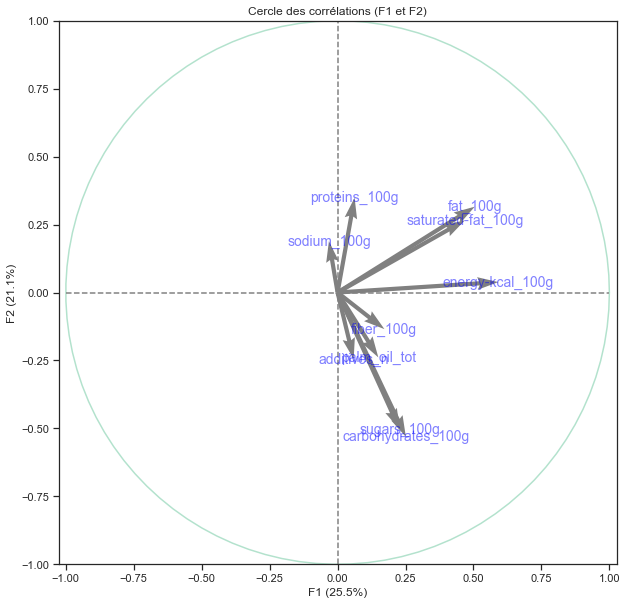

In [81]:
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

- F1 (25.5%) : Energie en calories et lipides (+ graisses saturées)
- F2 (21.1%) : Glucides (+ sucres), Protéines, Sodium, Fibres, Additifs et Huile de palme

=> 46.6% de variance expliquée

## VI - Apprentissage non-supervisée

### a) Définition de l'algorithme

In [82]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from yellowbrick.style import set_palette
set_palette('sns_pastel')

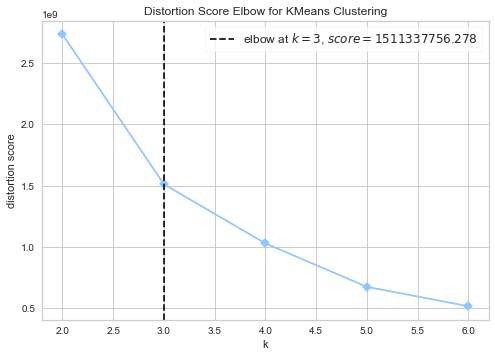

In [83]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(2,7), metric='distortion', timings=False
)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

In [84]:
# paramétrage de la palette de couleurs Seaborn
sns.set_theme(style="ticks", palette="Pastel2")

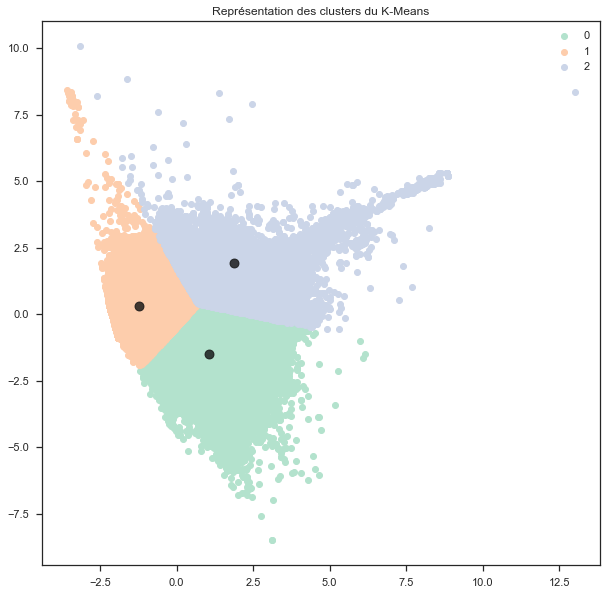

In [85]:
km = KMeans(n_clusters=3)

#Prédiction
label = km.fit_predict(pca_components)
 
centroids = km.cluster_centers_
u_labels = np.unique(label)

#Représentation graphique:

plt.figure(figsize=(10,10))
for i in u_labels:
    plt.scatter(pca_components[label == i , 0] , pca_components[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, alpha = 0.8, color = 'k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.savefig("Présentation/Images/representation_kmeans.png")
plt.show()

In [116]:
from sklearn.pipeline import Pipeline

my_model = Pipeline([('scaler', StandardScaler()),
                     ('pca', PCA(n_components=2)),
                     ('kmeans', KMeans(n_clusters=3))])
my_model.fit(X_scaled)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('kmeans', KMeans(n_clusters=3))])

In [117]:
import joblib
 
# Sauvegarde du modèle
joblib.dump(my_model, 'nutravel_model.pkl')

['nutravel_model.pkl']

### b) Analyses des clusters obtenus

In [90]:
df_france['Clusters'] = km.labels_

In [91]:
print("Score de silhouette :", silhouette_score(pca_components,labels=km.labels_).round(3))

Score de silhouette : 0.485


In [92]:
print("Score de Davies-Bouldin :", davies_bouldin_score(pca_components, labels=km.labels_).round(3))

Score de Davies-Bouldin : 0.773


In [93]:
print("Nombre de produits :", df_france['product_name'].loc[df_france['Clusters'] == 0].count())

Nombre de produits : 72353


In [94]:
print("Nombre de produits :", df_france['product_name'].loc[df_france['Clusters'] == 1].count())

Nombre de produits : 117861


In [95]:
print("Nombre de produits :", df_france['product_name'].loc[df_france['Clusters'] == 2].count())

Nombre de produits : 37179


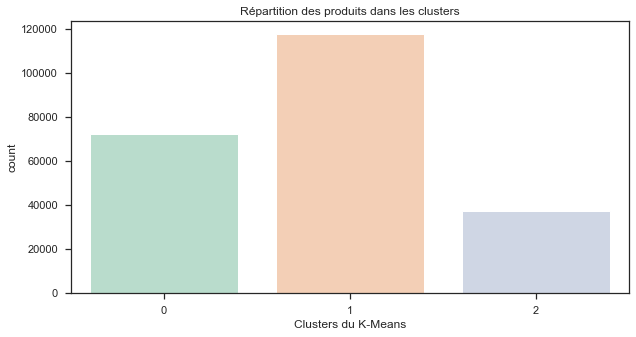

In [96]:
plt.figure(figsize=(10,5))
sns.countplot(x="Clusters", data=df_france)
plt.xlabel("Clusters du K-Means")
plt.title("Répartition des produits dans les clusters")
plt.savefig("Présentation/Images/repartition_kmeans.png")
plt.show()

In [97]:
stats_descr = df_france.groupby("Clusters").mean().round(3)
stats_descr.drop(['ingredients_from_palm_oil_n', "ingredients_that_may_be_from_palm_oil_n", "nova_group",'created_years', 'last_modified_years'], axis=1, inplace=True)
stats_descr

,additives_n,energy-kcal_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,palm_oil_tot
Clusters,,,,,,,,,,
0,2.190,389.847,13.869,5.796,59.175,30.796,3.379,6.343,0.209,0.325
1,1.317,130.913,5.886,1.912,10.597,4.716,1.122,7.550,0.434,0.027
2,0.866,492.300,44.263,17.291,8.897,4.426,2.030,14.964,0.547,0.040


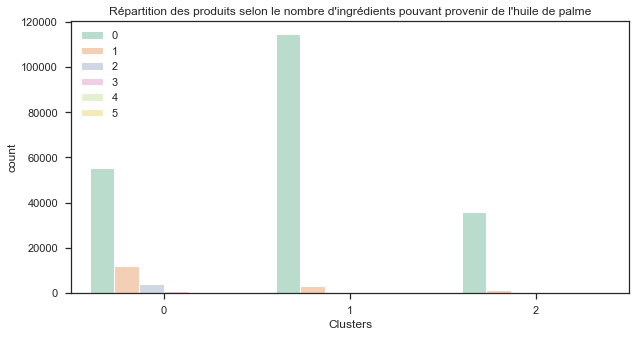

In [98]:
plt.figure(figsize=(10,5))
sns.countplot(x="Clusters", hue="palm_oil_tot", data=df_france)
plt.title("Répartition des produits selon le nombre d'ingrédients pouvant provenir de l'huile de palme")
plt.legend(loc="best")
plt.savefig("Présentation/Images/repartition_produits_palm_oil_cluster.png")
plt.show()

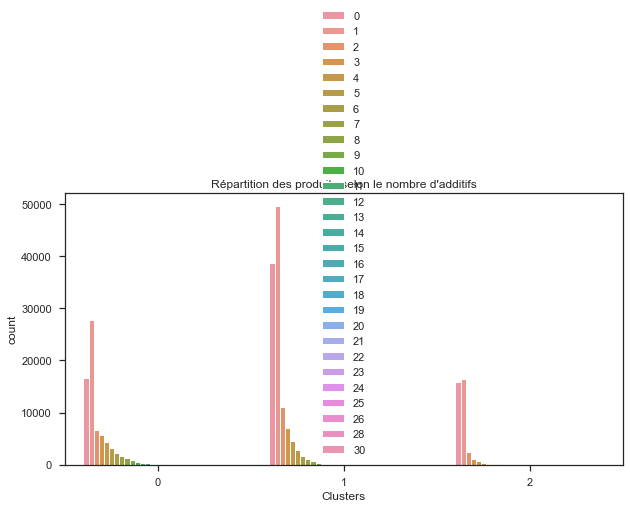

In [99]:
plt.figure(figsize=(10,5))
sns.countplot(x="Clusters", hue="additives_n", data=df_france)
plt.title("Répartition des produits selon le nombre d'additifs")
plt.legend()
plt.savefig("Présentation/Images/repartition_produits_additifs_cluster.png")
plt.show()

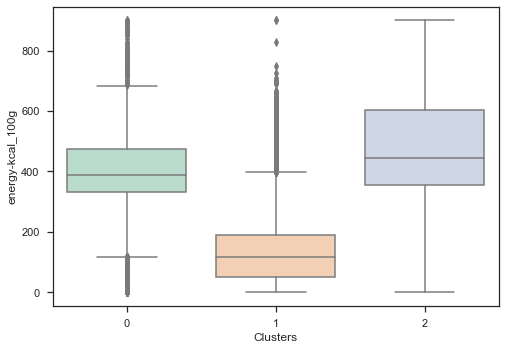

In [100]:
sns.boxplot(x="Clusters", y="energy-kcal_100g", data=df_france)
plt.show()

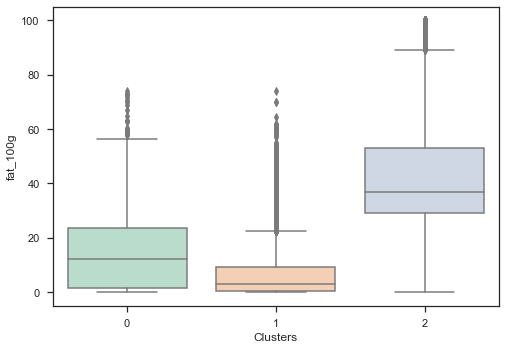

In [101]:
sns.boxplot(x="Clusters", y="fat_100g", data=df_france)
plt.show()

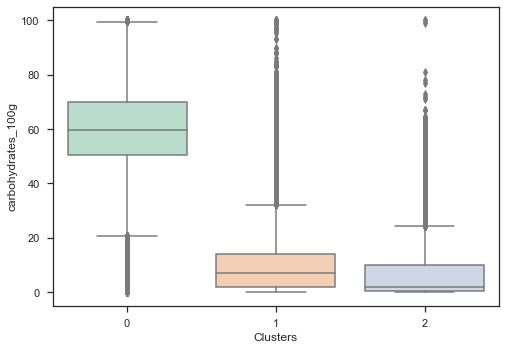

In [102]:
sns.boxplot(x="Clusters", y="carbohydrates_100g", data=df_france)
plt.show()

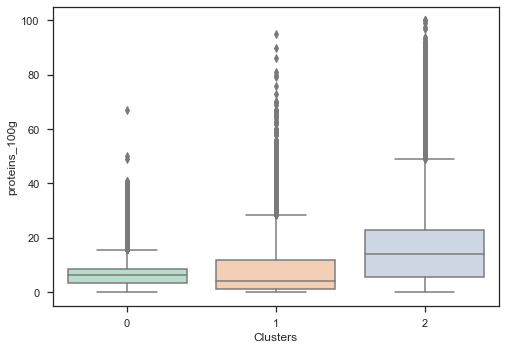

In [103]:
sns.boxplot(x="Clusters", y="proteins_100g", data=df_france)
plt.show()

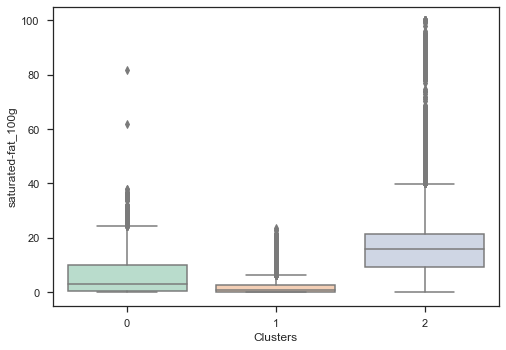

In [104]:
sns.boxplot(x="Clusters", y="saturated-fat_100g", data=df_france)
plt.show()

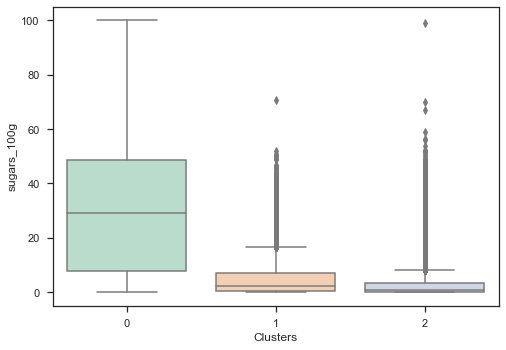

In [105]:
sns.boxplot(x="Clusters", y="sugars_100g", data=df_france)
plt.show()

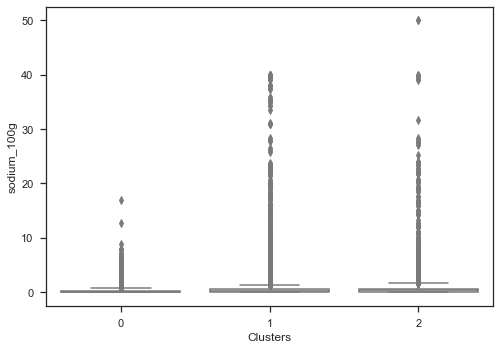

In [106]:
sns.boxplot(x="Clusters", y="sodium_100g", data=df_france)
plt.show()

### c) Prédiction du cluster d'appartenance d'un produit

In [107]:
df["palm_oil_tot"] = df["ingredients_from_palm_oil_n"] + df["ingredients_that_may_be_from_palm_oil_n"]

In [108]:
produit = df.loc[df["product_name"] == "Топено сирене с пушена шунка"]

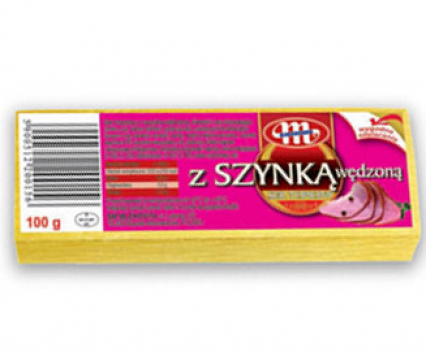

Plus d'informations : [ici](!https://www.supermag.bg/food_products/mlechni-produkti/Topeno_sirene_i_izvara/view?iid=116537)

In [109]:
produit = produit[["additives_n", 'energy-kcal_100g', "saturated-fat_100g", "fat_100g","sugars_100g", "carbohydrates_100g",
                   'proteins_100g', 'sodium_100g', "fiber_100g", "palm_oil_tot"]]

In [110]:
print(produit)

         additives_n  energy-kcal_100g  saturated-fat_100g  fat_100g  \
1279874            6             295.0                17.0      27.0   

         sugars_100g  carbohydrates_100g  proteins_100g  sodium_100g  \
1279874          3.0                 3.0           10.0          0.8   

         fiber_100g  palm_oil_tot  
1279874         0.0             0  


In [118]:
nutravel = joblib.load('nutravel_model.pkl')
print(my_model.predict(produit))

[2]
